# Predicting driving speed violations with the Amazon SageMaker DeepAR algorithm
_**Using the Amazon SageMaker DeepAR algorithm to predict streets where motorists are most likely to drive above speed limits at different times of the year**_

---

---


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Extensions](#Extensions)

---

## Background

This notebook demonstrates time series forecasting using the Amazon SageMaker DeepAR algorithm by analyzing city of Chicago’s [Speed Camera Violation dataset](https://data.cityofchicago.org/Transportation/Red-Light-Camera-Violations/spqx-js37). The dataset is hosted by [Data.gov](https://data.gov), and is managed by the [U.S. General Services Administration, Technology Transformation Service](http://www.gsa.gov/portal/category/25729).

These violations are captured by camera systems and available to improve the lives of public through the [city of Chicago data portal](https://data.cityofchicago.org/). The [Speed Camera Violation  dataset](https://data.cityofchicago.org/Transportation/Red-Light-Camera-Violations/spqx-js37) can be used to discern patterns in the data and gain meaningful insights.

The dataset contains multiple camera locations and daily violation counts. Each daily violations for a camera can be considered a separate time series. Amazon SageMaker’s DeepAR algorithm can be used to train a model for multiple streets simultaneously, and predict violation for multiple street cameras using the Amazon SageMaker’s [DeepAR algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

---

## Setup

This notebook was created and tested on an ml.m4.xlarge notebook instance.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the notebook instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace `sagemaker.get_execution_role()` with the appropriate full IAM role arn string(s).

In [1]:
import sagemaker

sess = sagemaker.Session()
#bucket = sess.default_bucket()
bucket = 'fab-sagemaker'
prefix = 'deepar-forecasting-traffic-chicago' # change to your desired S3 prefix
region = sess.boto_region_name

role = sagemaker.get_execution_role()

Now we import Python libraries like s3fs, matplotlib, pandas and numpy

In [2]:
import io
import json
import requests
import time

import matplotlib.pyplot as plt
import pandas as pd

!conda install -y s3fs
import s3fs

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::nbconvert==5.6.1=py36_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/noarch::jupyterlab_server==1.0.6=py_0
  - defaults/linux-64::nump

---

## Data



The speed violations are captured by camera systems and available to improve the lives of public from the city of Chicago data portal. The Speed Camera Violation dataset can be used to discern patterns in the data and gain meaningful insights.

The dataset contains multiple camera locations and daily violation counts. If we imagine that each daily violations for a camera as one time series, we can use Amazon SageMaker’s DeepAR algorithm to train a model for multiple streets simultaneously, and predict violation for multiple street cameras using the Amazon SageMaker’s DeepAR algorithm.

The dataset contains several columns, we use the address, violation date, violations for the forecasting.


In [3]:
datafile = 'Chicago_Speed_Camera_Violations.csv'
speeding_violation_data_path = '{}/{}/{}.csv'.format(bucket, prefix, datafile)
s3_output_path = '{}/{}/output'.format(bucket, prefix)
train_data_path = '{}/{}/train/train.json'.format(bucket, prefix)
test_data_path = '{}/{}/test/test.json'.format(bucket, prefix)

url = 'https://data.cityofchicago.org/api/views/hhkd-xvj4/rows.csv?accessType=DOWNLOAD'

# get the data from City of Chicago site
r = requests.get(url, allow_redirects=True)
open(datafile, 'wb').write(r.content)
  
# read the input file, and display sample rows/columns
pd.set_option('display.max_columns', 500)     
pd.set_option('display.max_rows', 50)    
df = pd.read_csv(open(datafile, 'rb'), encoding='utf-8')

# print first 10 lines to look at part of the dataset
df[['ADDRESS', 'VIOLATION DATE', 'VIOLATIONS']][0:10]

,ADDRESS,VIOLATION DATE,VIOLATIONS
0,1111 N HUMBOLDT,04/10/2015,67
1,1111 N HUMBOLDT,04/25/2015,71
2,1111 N HUMBOLDT,04/14/2015,38
3,1111 N HUMBOLDT,04/16/2015,55
4,1111 N HUMBOLDT,04/24/2015,54
5,5520 S WESTERN,04/26/2015,35
6,5520 S WESTERN,08/07/2014,42
7,5529 S WESTERN,08/07/2014,21
8,5529 S WESTERN,07/07/2014,14
9,5520 S WESTERN,08/04/2014,26


We convert the violation date from string format to date format, determine the range of violation dates, and look at how many unique street addresses/cameras we have in our dataset.

The dataset contains multiple camera locations and daily violation counts. If we imagine that each camera's daily violations as one time series, we can use Amazon SageMaker’s DeepAR algorithm to train a model for multiple streets simultaneously, and predict the violation count for multiple street cameras using the Amazon SageMaker’s DeepAR algorithm.

As described in [Amazon SageMaker DeepAR input/output interface](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput) section, we will convert the data into array, and use 0 for the violation count when data for a given camera on a given date is not available. Using the Matplotlib library we display each camera location as a timeseries to visualize the data


Unique Addresses 164
Minimum violation date is 2014-07-01 00:00:00, maximum violation date is 2020-09-29 00:00:00


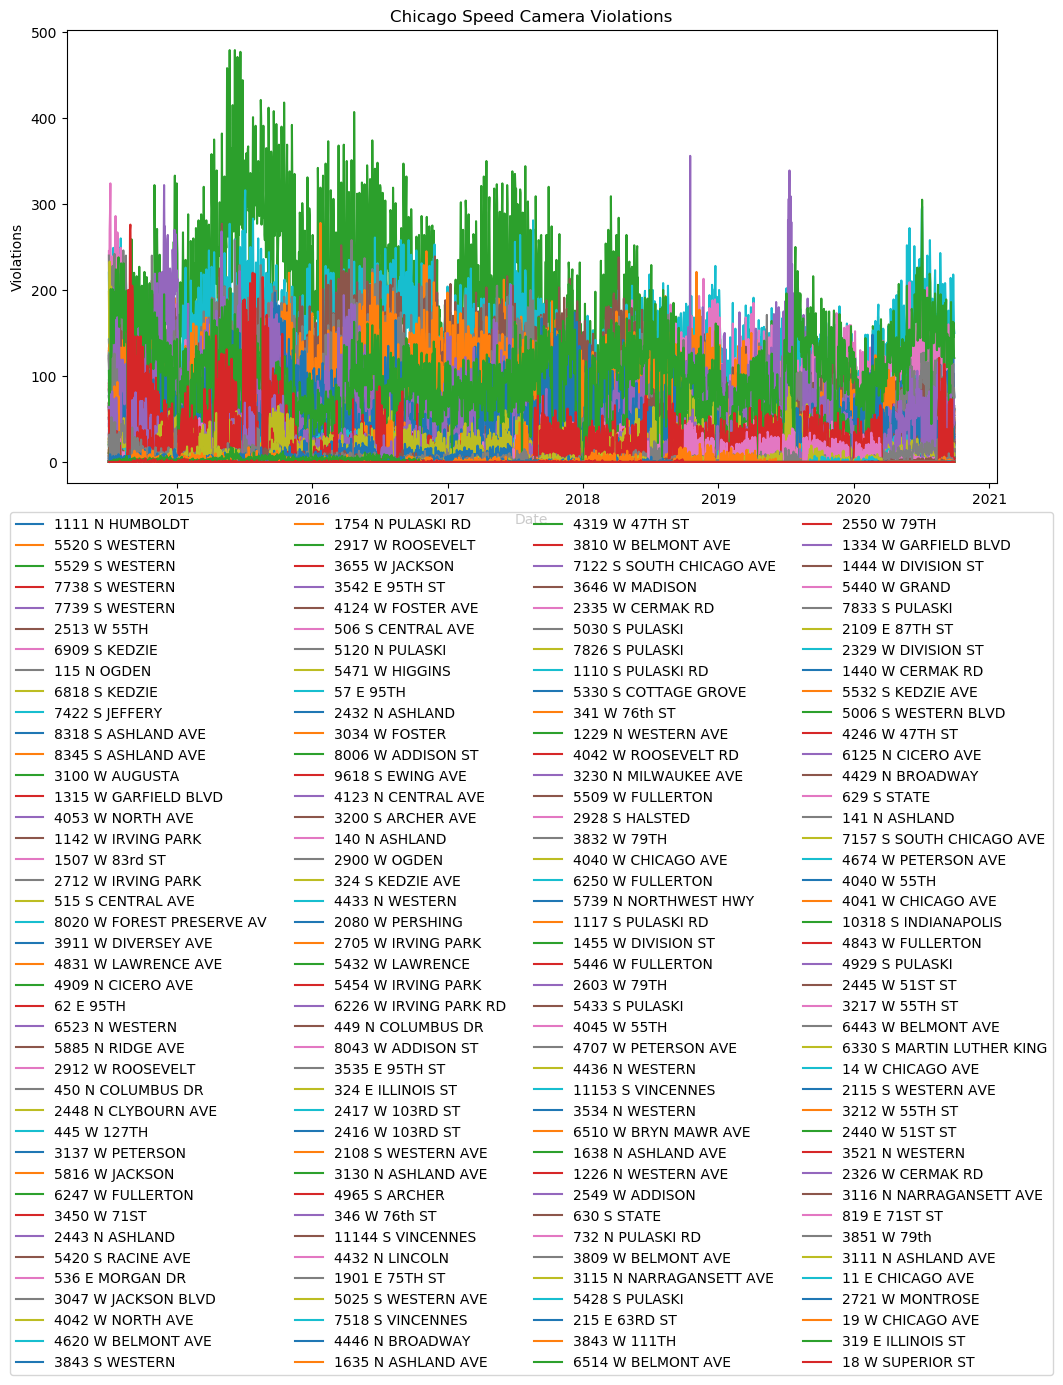

In [4]:
df['VIOLATION_DT'] = pd.to_datetime(df['VIOLATION DATE'])
df[['ADDRESS', 'VIOLATION_DT', 'VIOLATIONS']]
unique_addresses = df.ADDRESS.unique()
idx = pd.date_range(df.VIOLATION_DT.min(), df.VIOLATION_DT.max())
number_of_addresses = len(unique_addresses)
print('Unique Addresses {}'.format(number_of_addresses))
print('Minimum violation date is {}, maximum violation date is {}'.format(df.VIOLATION_DT.min(), df.VIOLATION_DT.max()))


violation_list = []
for key in unique_addresses:
    temp_df = df[['VIOLATION_DT', 'VIOLATIONS']][df.ADDRESS == key]
    temp_df.set_index(['VIOLATION_DT'], inplace=True)
    temp_df.index = pd.DatetimeIndex(temp_df.index)
    temp_df = temp_df.reindex(idx, fill_value=0)
    violation_list.append(temp_df['VIOLATIONS'])

plt.figure(figsize=(12,6), dpi=100, facecolor='w')
for key, address in enumerate(unique_addresses):
    plt.plot(violation_list[key], label=address)

plt.ylabel('Violations')
plt.xlabel('Date')
plt.title('Chicago Speed Camera Violations')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

We define prediction length as 30 days, and split the data with last 30 days of data as test data. We use rest of the data for training of the model. We can use the last 30 days of data to evaluate the accuracy of our trained model. We write the training and test data files in JSON format in the S3 bucket. 

In [5]:
prediction_length = 30

# Split the data for training and validation/hold out
violation_list_training = []
for i in violation_list:
    violation_list_training.append((i[:-prediction_length]))

def series_to_obj(ts, cat=None):
    obj = {'start': str(ts.index[0]), 'target': list(ts)}
    if cat:
        obj['cat'] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = 'utf-8'
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(train_data_path, 'wb') as fp:
    for ts in violation_list_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(test_data_path, 'wb') as fp:
    for ts in violation_list:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))


---

## Train

We use [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) to create an [estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html) object to kick off training job. The train_use_spot parameter indicates the use of [managed spot training](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html). The training will run at most 1 hour (3600 seconds). 

We use the [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) or Hyperparameter optimization for identifying the best values for the [DeepAR hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html). The Automatic Model Tuning job will kick of 10 parallel jobs (set by by max_parallel_jobs) to search the best hyperparameters for this dataset. The jobs will try to minimize the root mean square error on the test dataset using predicted and actual values.

You can consider increasing the max_parallel_jobs and train_max_run and train_max_wait parameters to allow for finding better hyperparameters, and allow additional tuning of the hyperparameters.



In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri


container = get_image_uri(region_name=region,
                          repo_name='forecasting-deepar')

deepar = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count=1,
                                       train_instance_type='ml.m4.xlarge',
                                       train_use_spot_instances=True, # use spot instances
                                       train_max_run=3600, # max training time in seconds
                                       train_max_wait=3600, # seconds to wait for spot instance
                                       output_path='s3://{}/{}'.format(bucket, s3_output_path),
                                       sagemaker_session=sess)
freq = 'D'
context_length = 30

deepar.set_hyperparameters(time_freq=freq,
                           context_length=str(context_length),
                           prediction_length=str(prediction_length))

hyperparameter_ranges = {'mini_batch_size': IntegerParameter(100, 400),
                         'epochs': IntegerParameter(200, 400),
                         'num_cells': IntegerParameter(30,100),
                         'likelihood': CategoricalParameter(['negative-binomial', 'student-T']),
                         'learning_rate': ContinuousParameter(0.0001, 0.1)}

objective_metric_name = 'test:RMSE'

tuner = HyperparameterTuner(deepar,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            strategy='Bayesian',
                            objective_type='Minimize',
                            max_parallel_jobs=10,
                            early_stopping_type='Auto')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(bucket, prefix),
                                    content_type='json')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix),
                                   content_type='json')

tuner.fit({'train': s3_input_train, 'test': s3_input_test}, 
          include_cls_metadata=False)
tuner.wait()

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


---

## Host

We use the [HyperParameterTuner](https://sagemaker.readthedocs.io/en/stable/tuner.html) to host the best model using a single ml.m4.xlarge instance.

In [7]:
best_tuning_job_name = tuner.best_training_job()
endpoint_name = tuner.deploy(initial_instance_count=1,
                             endpoint_name=best_tuning_job_name,
                             instance_type='ml.m4.xlarge',
                             wait=True)


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-13 15:55:20 Starting - Preparing the instances for training
2020-10-13 15:55:20 Downloading - Downloading input data
2020-10-13 15:55:20 Training - Training image download completed. Training in progress.
2020-10-13 15:55:20 Uploading - Uploading generated training model
2020-10-13 15:55:20 Completed - Training job completedArguments: train
[10/13/2020 15:09:21 INFO 140288105060160] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/13/2020 

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


[10/13/2020 15:50:55 INFO 140288105060160] Epoch[257] Batch [5]#011Speed: 436.68 samples/sec#011loss=2.274609
[10/13/2020 15:50:59 INFO 140288105060160] Epoch[257] Batch[10] avg_epoch_loss=1.998374
[10/13/2020 15:50:59 INFO 140288105060160] #quality_metric: host=algo-1, epoch=257, batch=10 train loss <loss>=1.6668921321
[10/13/2020 15:50:59 INFO 140288105060160] Epoch[257] Batch [10]#011Speed: 427.83 samples/sec#011loss=1.666892
[10/13/2020 15:50:59 INFO 140288105060160] processed a total of 3332 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 9964.427947998047, "sum": 9964.427947998047, "min": 9964.427947998047}}, "EndTime": 1602604259.01639, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1602604249.051438}

[10/13/2020 15:50:59 INFO 140288105060160] #throughput_metric: host=algo-1, train throughput=334.385067586 records/second
[10/13/2020 15:50:59 INFO 140288105060160] #progress_metric: host=algo-1, completed 91 % 

### Evaluate

To evaluate the model, we define a DeepARPredictor class. This class extends the [RealTimePredictor](https://sagemaker.readthedocs.io/en/stable/predictors.html) class. Implementing encode and decode functions helps us make requests using `pandas.Series` objects rather than raw JSON strings.
    

In [8]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be 
        called before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
       
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding='utf-8', num_samples=100, quantiles=['0.1', '0.5', '0.9']):
        """Requests the prediction of for the time series listed in `ts`, each with the 
        (optional) corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + x.index.freq for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {'num_samples': num_samples, 'output_types': ['quantiles'], 'quantiles': quantiles}
        http_request_data = {'instances': instances, 'configuration': configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df


predictor = DeepARPredictor(endpoint=best_tuning_job_name,
                            sagemaker_session=sess,
                            content_type='application/json')


Now we can use the previously created `predictor` object. We will predict only the first few time series, and compare the results with the actual data we kept in the test set.

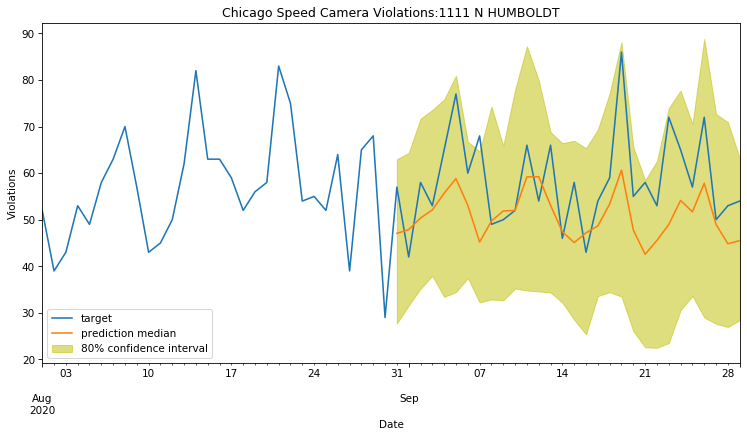

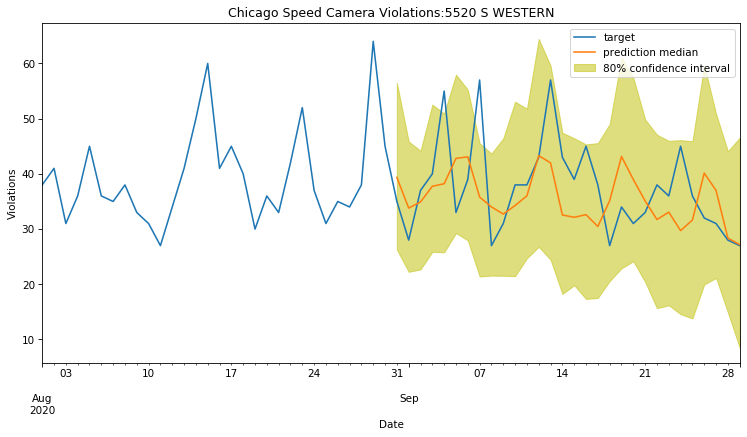

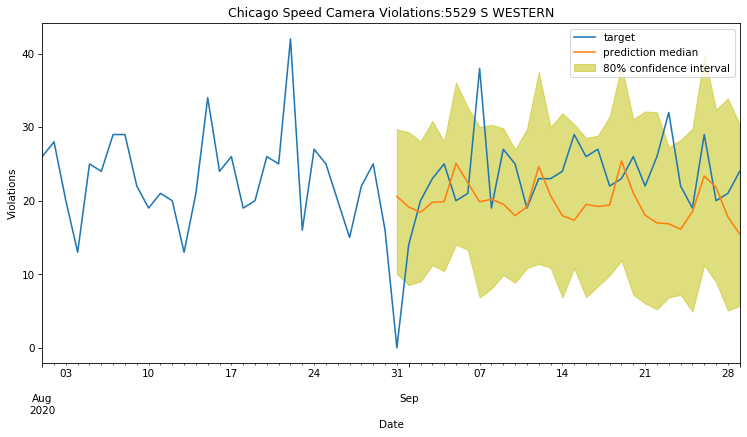

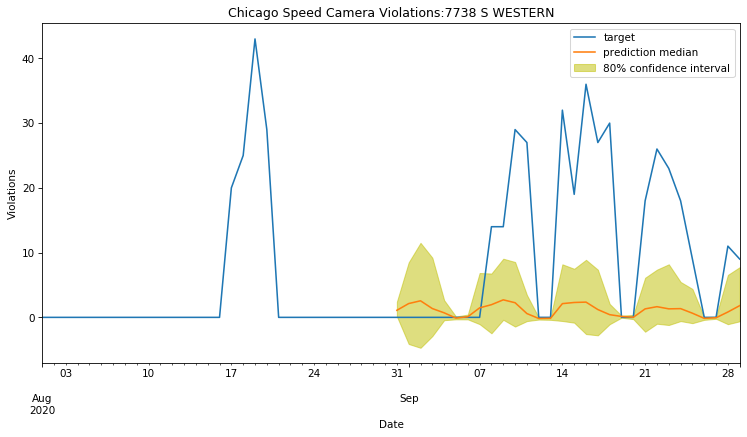

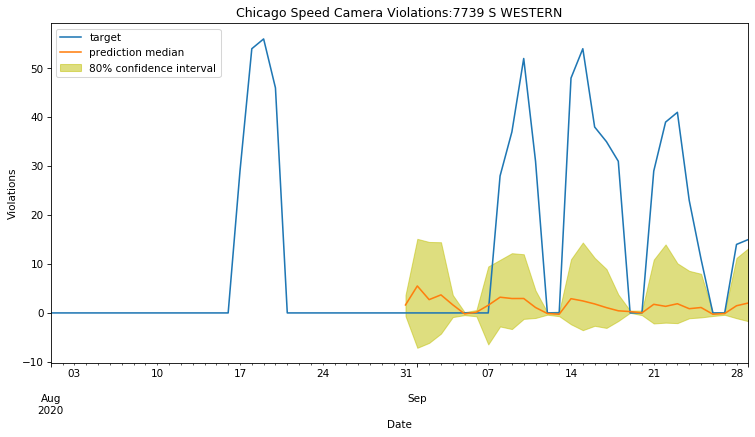

In [9]:
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(violation_list_training[:5])
actual_data = violation_list[:5]
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6), dpi=75, facecolor='w')
    plt.ylabel('Violations')
    plt.xlabel('Date')
    plt.title('Chicago Speed Camera Violations:' + unique_addresses[k])
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5,label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()


---

### Clean-up

At the end of this exercise, delete the endpoint to avoid accumulating charges in your account.

In [ ]:
predictor.delete_endpoint(endpoint_name)